In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./output/preprocessed_data.csv")
df.head()

,id,title,tags,domain,description
0,11-1011.00,chief executives,"['structured', 'versus', 'unstructured', 'work']",incumbent,determine formulate policies provide overall d...
1,11-1011.00,chief executives,['initiative'],incumbent,determine formulate policies provide overall d...
2,11-1011.00,chief executives,"['letters', 'memos']",incumbent,determine formulate policies provide overall d...
3,11-1011.00,chief executives,"['time', 'pressure']",incumbent,determine formulate policies provide overall d...
4,11-1011.00,chief executives,"['arm', 'hand', 'steadiness']",analyst,determine formulate policies provide overall d...


In [3]:
arxiv_data = df.drop(['id','domain'], axis=1)
arxiv_data.rename(columns = {'title':'titles', 'description':'summaries','tags':'terms'}, inplace=True)
arxiv_data.head()

,titles,terms,summaries
0,chief executives,"['structured', 'versus', 'unstructured', 'work']",determine formulate policies provide overall d...
1,chief executives,['initiative'],determine formulate policies provide overall d...
2,chief executives,"['letters', 'memos']",determine formulate policies provide overall d...
3,chief executives,"['time', 'pressure']",determine formulate policies provide overall d...
4,chief executives,"['arm', 'hand', 'steadiness']",determine formulate policies provide overall d...


In [4]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 38720 rows in the dataset.


In [5]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 37752 duplicate titles.


In [46]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 968 rows in the deduplicated dataset.
432
588


In [42]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(536, 3)

##### Convert the string labels to lists of strings

In [8]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['structured', 'versus', 'unstructured', 'work']),
       list(['importance', 'repeating', 'tasks']),
       list(['concern', 'others']),
       list(['management', 'financial', 'resources']),
       list(['project', 'management', 'software'])], dtype=object)

#### Use stratified splits because of class imbalance

In [9]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split, stratify=arxiv_data_filtered["terms"].values,
    )

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 375
Number of rows in validation set: 80
Number of rows in test set: 81


#### Multi-label binarization

In [10]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'software', 'time', 'spend', 'exposed', 'work', 'microsoft', 'equipment', 'control', 'others', 'flexibility', 'body', 'vision', 'speed', 'safety', 'management', 'comprehension', 'orientation', 'gross', 'computers', 'making', 'office', 'hearing', 'data', 'coordination', 'attention', 'word', 'suite', 'structured', 'stamina', 'resources', 'reasoning', 'monitoring', 'level', 'indoors', 'importance', 'environmentally', 'controlled', 'competition', 'written', 'versus', 'unstructured', 'strength', 'results', 'query', 'outdoors', 'operation', 'excel', 'equilibrium', 'contaminants', 'analysis', 'week', 'weather', 'wear', 'user', 'typical', 'thinking', 'stooping', 'speech', 'sitting', 'shoes', 'service', 'repetitive', 'proximity', 'protective', 'protection', 'processing', 'precision', 'physical', 'personal', 'oral', 'night', 'movement', 'motions', 'mathematical', 'material', 'listening', 'limb', 'lighting', 'life', 'lead', 'kneeling', 'jackets', 'interface', 'inadequate', 

2022-04-29 11:28:12.138984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['instructing']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


##### Data preprocessing of Descriptions

In [12]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    375.000000
mean      20.216000
std        9.893214
min        4.000000
25%       12.500000
50%       18.000000
75%       26.000000
max       61.000000
Name: summaries, dtype: float64

In [13]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [14]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [15]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'collect dump refuse recyclable materials containers truck may drive truck'
Label(s): ['thinking' 'critical']
 
Abstract: b'supervise coordinate activities slot department workers provide service patrons handle settle complaints players verify pay jackpots reset slot machines payoffs make repairs adjustments slot machines recommend removal slot machines repair report hazards enforce safety rules'
Label(s): ['software' 'management' 'project']
 
Abstract: b'paint walls equipment buildings bridges structural surfaces using brushes rollers spray guns may remove old paint prepare surface prior painting may mix colors oils obtain desired color consistency'
Label(s): ['memos' 'letters']
 
Abstract: b'operate one variety office machines photocopying photographic duplicating machines office machines'
Label(s): ['software' 'mail' 'electronic']
 
Abstract: b'diagnose treat help prevent injuries occur sporting events athletic training physical activities'
Label(s): ['time' 'spend' 'stoo

In [16]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

2707


In [17]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [18]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/20
3/3 [==============================] - 1s 93ms/step - loss: 0.7400 - categorical_accuracy: 0.0000e+00 - val_loss: 0.4445 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 40ms/step - loss: 0.3877 - categorical_accuracy: 0.0027 - val_loss: 0.2198 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 0s 40ms/step - loss: 0.1994 - categorical_accuracy: 0.0000e+00 - val_loss: 0.1109 - val_categorical_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 0s 42ms/step - loss: 0.1044 - categorical_accuracy: 0.0107 - val_loss: 0.0962 - val_categorical_accuracy: 0.0375
Epoch 5/20
3/3 [==============================] - 0s 44ms/step - loss: 0.0843 - categorical_accuracy: 0.0373 - val_loss: 0.1058 - val_categorical_accuracy: 0.0500
Epoch 6/20
3/3 [==============================] - 0s 41ms/step - loss: 0.0852 - categorical_accuracy: 0.0693 - val_loss: 0.1111 - val_categorical_accuracy: 0.0500
Ep

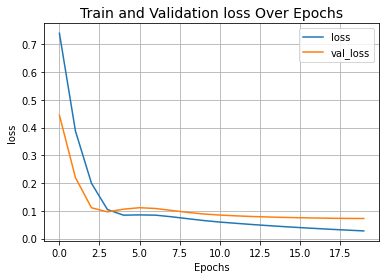

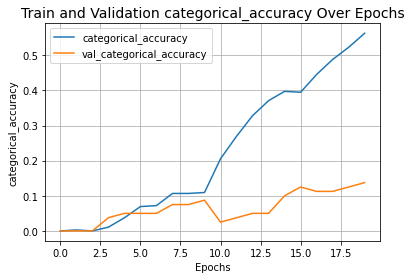

In [19]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [22]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc *10, 2)}%.")

1/1 [==============================] - 0s 84ms/step - loss: 0.0737 - categorical_accuracy: 0.0741
Categorical accuracy on the test set: 0.74%.


In [47]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(50), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'set operate variety drills remove underground oil gas remove core samples testing oil gas exploration'
Label(s): ['exposed' 'equipment' 'hazardous']
Predicted Label(s): (spend, time, orientation)
 
Abstract: b'verify maintain records incoming outgoing shipments prepare items shipment duties include assembling addressing stamping shipping merchandise material receiving unpacking verifying recording incoming merchandise material arranging transportation products'
Label(s): ['thinking' 'critical']
Predicted Label(s): (software, exposed, work)
 
Abstract: b'attend live farm ranch aquacultural animals may include cattle sheep swine goats horses equines poultry finfish shellfish bees attend animals produced animal products meat fur skins feathers eggs milk honey duties may include feeding watering herding grazing castrating branding de beaking weighing catching loading animals may maintain records animals examine animals detect diseases injuries assist birth deliveries administer